# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
openai = OpenAI()

In [4]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [6]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
DB = "products_vectorstore"

In [8]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [9]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [10]:
description(test[0])

'Front Complete Struts Ball Joints Tie Rods Links Replacement Parts For Armada 05-15 4 WHEEL DRIVE\nThis item is a Spring Struts + Chassis Parts. It will fit the following years and Replacement Parts For Nissan Armada 5.6L V8 4 WHEEL Replacement Parts For Infiniti QX56 5.6L Replacement Parts For Nissan Titan 5.6L V8 4 WHEEL DRIVEKit Includes ( 8pc Fits FRONT )2x Part# 11300 New Front Left & Right Complete Spring Struts PREMIUM BRAND 100% TESTED WITH VARI RATE SPRINGS & IMPROVED UPPER Part# K80647 New Lower Ball Part# New Front L & R Sway Bar Part# New Front'

In [11]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [12]:
def vector(item):
    return model.encode([description(item)])

In [13]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [14]:
test[1].prompt

'How much does this cost to the nearest dollar?\n\nHITBOX MIG 5 in 1 Gas MIG/Gasless Flux Core MIG/Stick/Lift TIG/Spot welding/Aluminum Multi Process Welding Machine with LED Digital Display\nDual Voltage 110V and 220V can be used.Powerful welding with ultra high current. Equipped with the latest IGBT inverter, the arc response is fast and stable,Suitable for all kinds of welding requirements solid wire, flux core wire, aluminum wire MIG welding can correspond to base material such as carbon steel, stainless steel, aluminum, iron. When welding aluminum, need to change our special aluminum liner to the torch. 2T / 4T / tap welding installation MIG welding can select 2T / 4T / tap welding mode. \n\nPrice is $350.00'

In [15]:
documents, prices = find_similars(test[1])

In [16]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
HITBOX MIG Welder 200A Dual Voltage Color Smart LCD Display IGBT Inverter Multifunction MIG MMA Lift TIG Stick Gas Mix Gases Gasless Flux Cored Wire Solid Core Wire Welding Machine
★ DUAL VOLTAGE MULTIFUNCTIONAL WELDER - HITBOX is dual voltage with MIG/ARC/LIFT TIG gas gasless multi Functions. It came with color LCD display with make the setting parameter very easy to read. It is super easy and convenient to chose the welding mode by pressing the “Selection” button. Once choosing the mode you need, the mode will light up with its matching color. ★ MIG FUNCTION - HITBOX welder supports gas, mix gas and gasless function. This welder can work with welding wire
Price is $249.99

Potentially related product:
HITBOX 6 in 1 MIG Welder, Ture 200Amp Multi process Aluminum Flux Core Welder 110V 220V Synergic Gas MIG/Gasless MIG/ARC/Lift TIG/Spool Gun/IGBT Quiet

In [17]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nHITBOX MIG Welder 200A Dual Voltage Color Smart LCD Display IGBT Inverter Multifunction MIG MMA Lift TIG Stick Gas Mix Gases Gasless Flux Cored Wire Solid Core Wire Welding Machine\n★ DUAL VOLTAGE MULTIFUNCTIONAL WELDER - HITBOX is dual voltage with MIG/ARC/LIFT TIG gas gasless multi Functions. It came with color LCD display with make the setting parameter very easy to read. It is super easy and convenient to chose the welding mode by pressing the “Selection” button. Once choosing the mode you need, the mode will light up with its matching color. ★ MIG FUNCTION - HITBOX welder supports gas, mix gas and gasless function. This welder can work with welding wire\nPrice is $249.99\n\nPotentially related product:\nHITBOX

In [18]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [19]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [20]:
gpt_4o_mini_rag(test[1])

369.99

In [21]:
test[1].price

349.99

1: Guess: $315.00 Truth: $337.45 Error: $22.45 SLE: 0.00 Item: Front Complete Struts Ball Joints Tie Ro...
2: Guess: $369.99 Truth: $349.99 Error: $20.00 SLE: 0.00 Item: HITBOX MIG Welder,200Amp 5 in 1 Gas MIG/...
3: Guess: $151.28 Truth: $90.06 Error: $61.22 SLE: 0.26 Item: EBC Brakes DP42069R Yellowstuff Street a...
4: Guess: $215.00 Truth: $382.07 Error: $167.07 SLE: 0.33 Item: Cardone 22-189 Remanufactured Hydraulic ...
5: Guess: $109.00 Truth: $129.00 Error: $20.00 SLE: 0.03 Item: DANSEER Moravian Star Light Modern Brass...
6: Guess: $380.97 Truth: $358.99 Error: $21.98 SLE: 0.00 Item: Firestone W217602190 Ride-Rite Kit for G...
7: Guess: $199.99 Truth: $298.97 Error: $98.98 SLE: 0.16 Item: AmeriLite 2007-2013 For Chevy Avalanche/...
8: Guess: $229.99 Truth: $135.00 Error: $94.99 SLE: 0.28 Item: SAMSUNG Galaxy Chromebook Go 2021 Laptop...
9: Guess: $199.99 Truth: $365.00 Error: $165.01 SLE: 0.36 Item: Targus Thunderbolt 3 Docking Station wit...
10: Guess: $39.99 Truth: $66.66 Erro

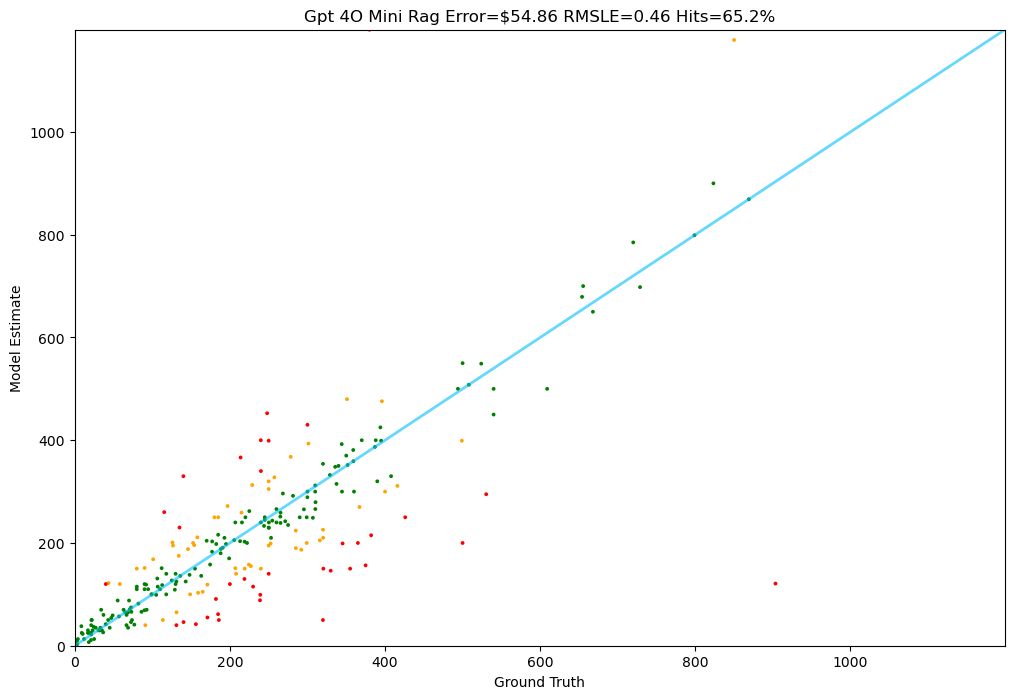

In [22]:
Tester.test(gpt_4o_mini_rag, test)

In [23]:
from agents.frontier_agent import FrontierAgent

In [24]:
agent = FrontierAgent(collection)

In [25]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

195.19

In [26]:
from agents.specialist_agent import SpecialistAgent

In [27]:
agent2 = SpecialistAgent()

In [28]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

220.0